In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio

import imageio
from PIL import Image, ImageSequence
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_dilation, grey_dilation
from skimage.feature import canny
import skimage.measure as measure
from skimage.measure import label
from skimage.segmentation.boundaries import find_boundaries
from skimage.measure import regionprops
import cv2
from skimage.filters import sobel
from skimage.morphology import watershed

In [2]:
import sys
sys.path.append('../src')
from image_cutout import *
from image_segmentation import segment_image, remove_border_cell

In [3]:
# load all pages of tiff file
tiff_dir = '../data/15052019_algMono0.1_20190517_tiff/'
path = tiff_dir + os.listdir(tiff_dir)[11]
all_pages = open_tiff(path)

In [4]:
len(all_pages)

200

#### Chamber detection for first image

In [5]:
# scale pixel-values
img = all_pages[0]
img = scale_pixel_vals(img)

In [6]:
#image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = img.astype('uint8')
enhanced = cv2.equalizeHist(img)

In [7]:
# apply dilation and find contours at a constant value
# automatic detection of color value
#dilation = grey_dilation(enhanced, size=(20,20)) #size=(20,20)
contours = measure.find_contours(enhanced, 180, fully_connected='high')

In [8]:
# closed_shape_ix = np.where([(c[:,1][0] == c[:,1][-1])&(c[:,0][0] == c[:,0][-1])\
#                             for c in contours])[0]
# closed_shapes = [contours[ix] for ix in closed_shape_ix]

# #find the rectangular contour
# x_range_contours = np.array([np.max(c[:,1]) - np.min(c[:,1]) for c in closed_shapes])
# y_range_contours = np.array([np.max(c[:,0]) - np.min(c[:,0]) for c in closed_shapes])

# #assume chamber size is above a specific value
# ix = list(set(np.where(x_range_contours > 400)[0])&set(np.where(y_range_contours > 400)[0]))

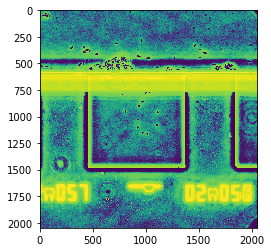

In [9]:
#plt.imshow(dilation)
#plt.plot(np.sum(dilation, axis = 1))
plt.imshow(enhanced)

In [10]:
# compute the range in x-direction for every contour and check for contours above a specific size
ix_rect = find_rectangle(contours, 700, 500)

In [11]:
# get the corners of the rectangle
corners = get_corners(contours[ix_rect])
rectangle_x, rectangle_y, range_x, range_y = draw_rectangle(corners)

corners_cut = get_corners(np.array([rectangle_y, rectangle_x]).T)
cutout = do_cutout(img, corners_cut)

Text(0.5, 1.0, 'Cutout')

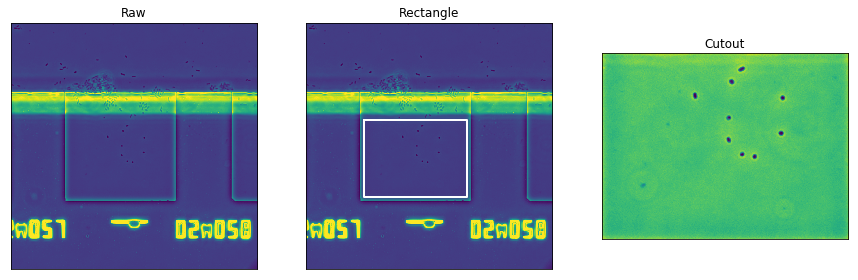

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Raw')
plt.subplot(1,3,2)
plt.imshow(img)
plt.plot(rectangle_x, rectangle_y, 'w', linewidth = 2)
plt.xticks([])
plt.yticks([])
plt.title('Rectangle')
plt.subplot(1,3,3)
plt.imshow(cutout)
plt.xticks([])
plt.yticks([])
plt.title('Cutout')

#### Chamber detection for all following images

In [13]:
# rescale pixel-values
img = all_pages[186]
img = scale_pixel_vals(img)

In [14]:
img = img.astype('uint8')
enhanced = cv2.equalizeHist(img)

In [15]:
# apply dilation and find contours at a constant value
# automatic detection of color value
#dilation = grey_dilation(enhanced, size=(20,20))
contours = measure.find_contours(enhanced, 180, fully_connected='high')

In [16]:
# x_range_contours = np.array([c[:,1] for c in contours])

# closed_rectangle_ix = np.where([c[:,1][0] == c[:,1][-1] for c in contours])[0]
# closed_rectangles = [contours[ix] for ix in closed_rectangle_ix]

# len(closed_rectangles)

In [17]:
# x_val = contours[40][:,1]
# #len(np.where(x_val == 0)[0])
# x_min_val = 0
# x_max_val = img.shape[0]
# y_min_val = 0
# y_max_val = img.shape[1]

In [18]:
# ix = 13
# plt.plot(contours[ix][:,1], contours[ix][:,0])
# (contours[ix][:,1][0] == contours[ix][:,1][-1])&(contours[ix][:,0][0] == contours[ix][:,0][-1])

In [19]:
# compute the range in x-direction for every contour and check for contours above a specific size
ix_rect = find_rectangle(contours, 700, 500)

In [20]:
# get the corners of the rectangle
corners = get_corners(contours[ix_rect])
rectangle_x, rectangle_y = draw_rectangle(corners, range_x, 
                                          range_y, first_image = False)
corners_cut = get_corners(np.array([rectangle_y, rectangle_x]).T)
cutout = do_cutout(img, corners_cut)

Text(0.5, 1.0, 'Cutout')

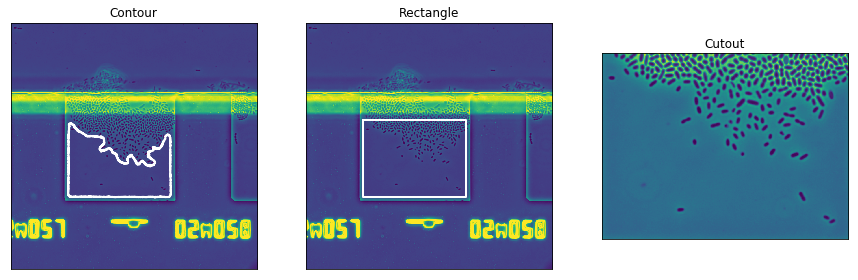

In [21]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Contour')
plt.plot(contours[ix_rect][:,1], contours[ix_rect][:,0], 'w', linewidth = 2)
plt.subplot(1,3,2)
plt.imshow(img)
plt.plot(rectangle_x, rectangle_y, 'w', linewidth = 2)
plt.xticks([])
plt.yticks([])
plt.title('Rectangle')
plt.subplot(1,3,3)
plt.imshow(cutout)
plt.xticks([])
plt.yticks([])
plt.title('Cutout')

#### Cutout all

In [22]:
#path = tiff_dir + os.listdir(tiff_dir)[35]
all_cutouts = cutout_all_pages(path, 700, 400)

100%|██████████| 200/200 [04:46<00:00,  1.38s/it]


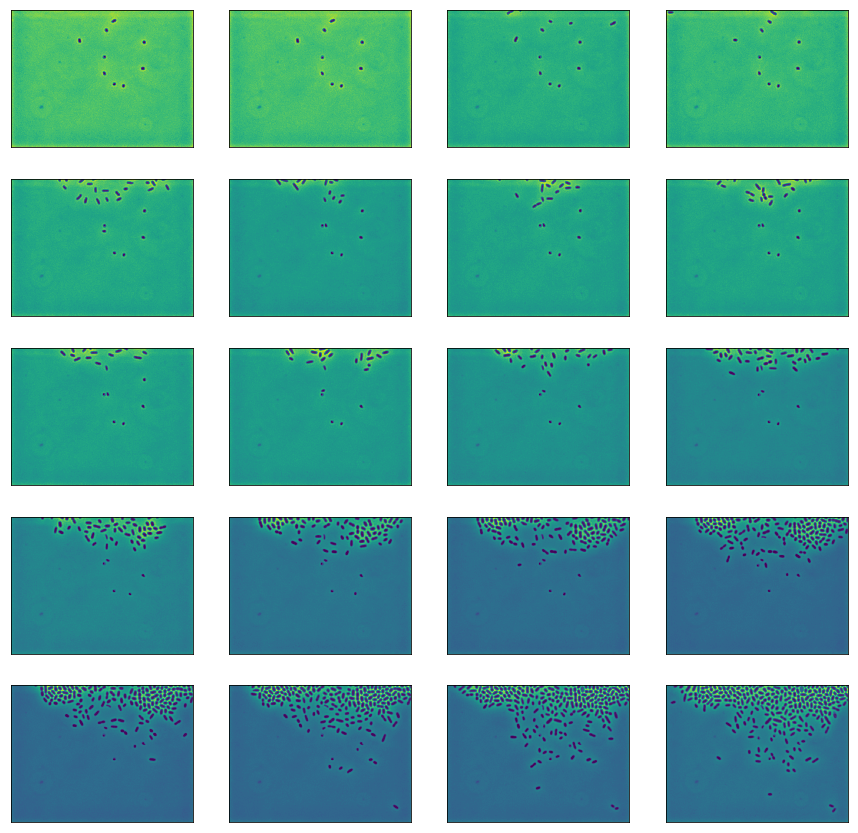

In [23]:
plt.figure(figsize = (15,15))
for i, ac in enumerate(all_cutouts[::10]):
    plt.subplot(5,4,i+1)
    plt.imshow(ac)
    plt.xticks([])
    plt.yticks([])

In [24]:
[ac.shape for ac in all_cutouts]

[(644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),
 (644, 855),

In [25]:
all_segmentations = [segment_image(ac) for ac in all_cutouts]

In [27]:
all_segms_clean = [remove_border_cell(s) for s in all_segmentations]

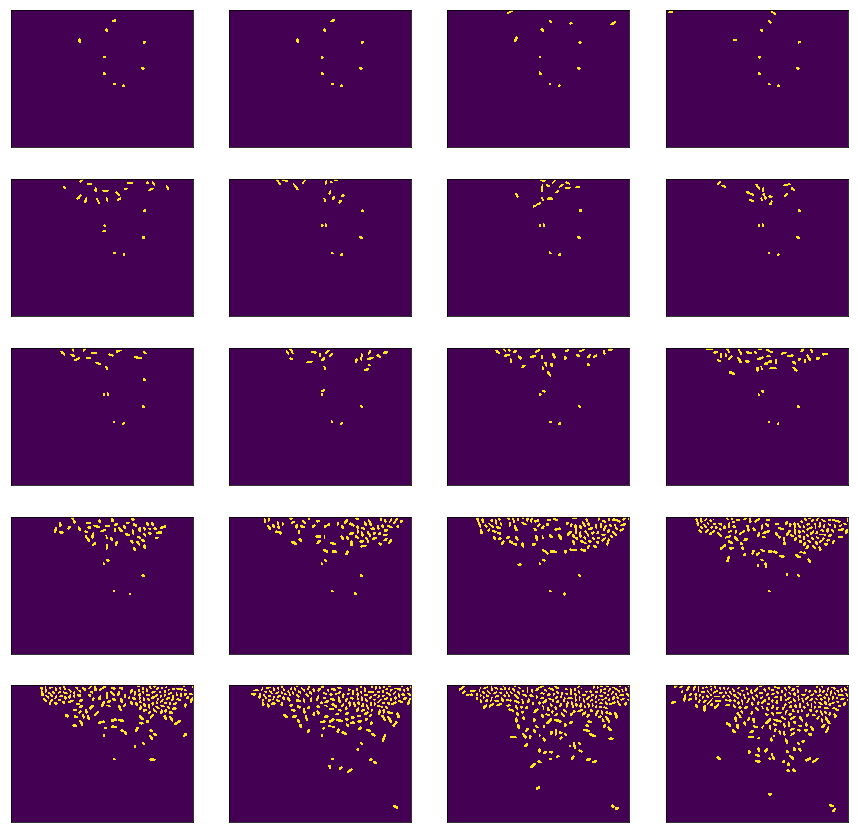

In [28]:
plt.figure(figsize = (15,15))
for i, ac in enumerate(all_segms_clean[::10]):
    plt.subplot(5,4,i+1)
    plt.imshow(ac)
    plt.xticks([])
    plt.yticks([])

#### Save all cutouts and segmentations

In [34]:
data_dir = '../data/15052019_algMono0.1_20190517_segm/'

In [35]:
# Save all pages to separate tif-files
im_dir = data_dir + 'raw_im/' 
fname_base = 'CWRt' 
for i, p in enumerate(all_pages):
    filename = im_dir + fname_base + str('{:05}'.format(i+1)) + 'xy001c1.tif'
    img = Image.fromarray(p)
    img.save(filename)

In [36]:
# generate one tif-file per timeframe for cutouts
phase_dir = data_dir + 'xy1/phase/'
fname_base = 'CWRt' 
for i, cut in enumerate(all_cutouts):
    filename = phase_dir + fname_base + str('{:05}'.format(i+1)) + 'xy001c1.tif'
    img = Image.fromarray(cut)
    img.save(filename)

In [38]:
# generate one mat-file per timeframe for segmentation images

# mname = segm_dir + os.path.splitext(os.path.basename(path))[0]
# sio.savemat(mname,{'ar' : np.array(all_cutouts)})

# seg_dir = data_dir + 'xy1/seg/'
# fname_base = 'CWRt' 
# for i, seg in enumerate(all_segmentations):
#     filename = seg_dir + fname_base + str('{:05}'.format(i+1)) + 'xy001_err'
#     sio.savemat(filename,{'mask_cell' : seg.astype(bool)})
#     filename = seg_dir + fname_base + str('{:05}'.format(i+1)) + 'xy001_seg'
#     sio.savemat(filename,{'mask_cell' : seg.astype(bool)})

seg_dir = data_dir + 'xy1/seg/'
fname_base = 'CWRt' 
ix = 0
for ph, seg in zip(all_cutouts, all_segmentations):
    
    #phase images
    phase = ph
     
    phase_centr = ph - ph.mean(axis=0)
    phase_norm = phase_centr / np.abs(phase_centr).max(axis=0)
    
    # mask background
    mask_bg = np.where(((seg * 1)<1),0,1).astype('uint8')
    
    # labeling of segmentations
    img_label = label(seg.astype(bool))
    bounds = find_boundaries(img_label)
    score = np.ones(np.max(img_label)).astype(int)
    scoreRaw = score * 50
    
    # detect and count all cells in image
    num_regs = np.max(img_label)#int(len(np.unique(img_label)))
    bin_ar = np.zeros(num_regs)
    
    props = regionprops(img_label)
#    BoundingBox = np.zeros(1, dtype = [(str(i+1), float, (1,4)) for i in range(num_regs)])
#     BoundingBox = np.zeros(1, dtype = [(str(i+1), float, (1,4)) for i in range(num_regs)])

    properties = []
    for i, p in enumerate(props):
#         bb_start = p.bbox[:2] 
#         bb_size = np.array(p.bbox[2:]) - np.array(p.bbox[:2])
#         bb = list(np.append(np.array(bb_start), bb_size))
        #BoundingBox[str(i+1)] = bb
        #p.zeros(1, dtype = [(str(i), float, (2, 2)) for i in range(3)])
#         bb_dict = dict()
#         bb_dict['BoundingBox'] = tuple(bb)

        min_col = p.bbox[1]
        min_row = p.bbox[0]
        diff_col = p.bbox[3] - p.bbox[1]
        diff_row = p.bbox[2] - p.bbox[0]
        bb = tuple([min_col+1, min_row+1, diff_col+1, diff_row+1])

#         x = mylist(bb)
#         bb_ar = np.array([x])
    
        bb_dict = np.zeros(1, dtype = [('Area', int, (1, 1)), ('BoundingBox', float, (1, 4))])
        bb_dict['Area'] = p.area
        bb_dict['BoundingBox'] = bb
        
        #bb = [[b] for b in bb]
        properties.append(bb_dict)
        #sorted(set(bb), key=list(bb).index)
        #BoundingBox['BoundingBox'] = list(bb)
    #BoundingBox = BoundingBox
    
    # vars to be defined
    mask_cell = (mask_bg - bounds - seg) > 0
    
    # image size and values
    min_col_bb = np.min([p[0][1][0][0] for p in properties])
    min_row_bb = np.min([p[0][1][0][1] for p in properties])

    max_col_bb = np.max([p[0][1][0][0] for p in properties])
    max_row_bb = np.max([p[0][1][0][1] for p in properties])

    crop_box = np.array([[min_row_bb, min_col_bb, max_row_bb, max_col_bb]]).astype(int)
#     crop_box = (0, 0) + (phase.shape)
    imRange = np.array([phase.min(), phase.max()])
    
#     # save as mat file
#     filename = seg_dir + fname_base + str('{:05}'.format(i+1)) + 'xy001_err'
#     sio.savemat(filename,{'phase' : phase, 'mask_bg' : mask_bg, 'mask_cell' : mask_cell.astype(bool),
#                           'phaseNorm' : phase_norm, 'crop_box' : crop_box,
#                           'segs' : {'segs_good' : seg.astype(bool), 'segs_3n' : bounds.astype(bool),
#                                     'segs_label' : img_label.astype(bool), 'score' : score, 'scoreRaw' : scoreRaw},
#                           'regs' : {'regs_label' : img_label, 'num_regs' : num_regs, 'score' : score,
#                                     'scoreRaw' : scoreRaw}})
    
    filename = seg_dir + fname_base + str('{:05}'.format(ix+1)) + 'xy001_seg'
    sio.savemat(filename,{'phase' : phase, 'mask_bg' : mask_bg.astype(float), 'mask_cell' : mask_cell.astype(bool), 
                          'crop_box' : crop_box,
                          'segs' : {'segs_good' : seg.astype(bool), 'segs_3n' : bounds.astype(bool),
                                                 'segs_label' : img_label.astype(bool), 'score' : score,
                                                 'scoreRaw' : scoreRaw, 'segs_bad' : seg.astype(bool)},
                          'regs' : {'regs_label' : img_label.astype(float), 'num_regs' : num_regs, 'score' : score,
                                                 'scoreRaw' : scoreRaw, 
                                    'props' :  properties}})
    
# , 'imRange' : imRange
# , 'phaseNorm' : phase_norm
# , 'C2phaseThresh' : bounds   
    
#     # save as mat file
#     sio.savemat(filename,{'phase' : ph.astype(bool), 'mask_bg' : seg.astype(bool), 
#                           'mask_colonies' : seg.astype(bool), 'mask_cell' : seg.astype(bool), 
#                           'regs' : {'regs_label' : seg.astype(bool), 'num_regs' : num_regs, 
#                           'divide' : [bin_ar], 'ehist' : bin_ar, 'stat0' : bin_ar}})
    
#     filename = seg_dir + fname_base + str('{:05}'.format(i+1)) + 'xy001_seg'
#     sio.savemat(filename,{'phase' : ph.astype(bool), 'mask_bg' : seg.astype(bool), 
#                           'mask_colonies' : seg.astype(bool), 'mask_cell' : seg.astype(bool), 
#                           'segs' : {'segs_3n' : bounds.astype(bool), 'segs_label' : seg.astype(bool)},
#                           'regs' : {'regs_label' : seg.astype(bool), 
#                           'num_regs' : num_regs, 'divide' : [bin_ar], 'ehist' : bin_ar, 'stat0' : bin_ar}})
    
    ix+=1

In [39]:
filename = seg_dir + '.doSegFull'
sio.savemat(filename, {})

In [49]:
bb+1

TypeError: can only concatenate tuple (not "int") to tuple

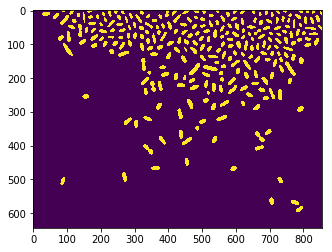

In [47]:
label_objects, nb_labels = ndi.label(seg)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 50
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]
plt.imshow(coins_cleaned)

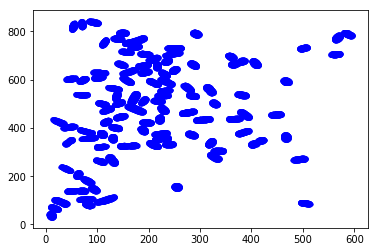

In [81]:
ix_cells = np.array([p.area for p in props]) > 200
prop_cells = np.array([p.coords for p in props])[ix_cells]

plt.figure()
for pc in prop_cells:
    plt.plot(pc[:,0], pc[:,1], 'b.')

In [ ]:
len(np.where(ix_cells == True)[0])

In [ ]:
seg

In [ ]:
plt.scatter(props[50].coords[:,0], props[50].coords[:,1])

In [ ]:
[p[0][0][0] for p in properties]

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(bounds[36:36+27,595:595+18])

In [ ]:
# min_col = p.bbox[1]
# min_row = p.bbox[0]
# diff_col = p.bbox[3] - p.bbox[1]
# diff_row = p.bbox[2] - p.bbox[0]
# tuple([min_col, min_row, diff_col, diff_row])

# min_col_bb = np.min([p[0][1][0][0] for p in properties])
# min_row_bb = np.min([p[0][1][0][1] for p in properties])

# max_col_bb = np.max([p[0][1][0][0] for p in properties])
# max_row_bb = np.max([p[0][1][0][1] for p in properties])

# np.array([[min_row_bb, min_col_bb, max_row_bb, max_col_bb]]).astype(int)

In [ ]:
imRange

In [ ]:
lib = sio.loadmat('../data/supersegger_test/xy1/seg/CWRt00001xy001_seg.mat')
lib['regs']['props'][0][0][0]